In [1]:
# import statements
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
from matplotlib.colors import LinearSegmentedColormap
import glob
import TestingTrainingSplit_CV

# Get names of models in which we are testing on
path_to_data = '/home/disk/pna2/aodhan/SurfaceTrendLearning/*_TrendMaps.nc'
ModelNames = [i[44:-16] for i in glob.glob(path_to_data)]

# Create Custom Color Map
colors = np.array([(22,98,248), (48,141,250), (71,172,251), (100,201,252), (129,222,253),(162,240,254), (215,249,253), (255,255,255), 
                   (255,255,255), (255,249,217), (247,236,155), (254,221,128), (254,202,100), (255,173,71), (252,142,42), (255,101,15)])/255
custom_cmap = LinearSegmentedColormap.from_list('cmap', colors)

# Do CV train-test-split 
TrainingPredictorData, TrainingTargetData, TestingPredictorData, TestingTargetData, TestingTotalTrend = TestingTrainingSplit_CV.training_testing_split()

In [2]:
from sklearn.cross_decomposition import PLSRegression
from scipy import stats

ERA5Trend1996_2014 = np.load('/home/disk/p/aodhan/SurfaceTrendLearing/FileCreators/ERA5Trend1996_2014.npy')
ERA5Trend1996_2014_reshaped = np.reshape(ERA5Trend1996_2014, (72*144))

# iterate over all CV folds (there should be eqaul number of CV folds as models)
NameValidatationPredictions = []
ERA5_predictions = []
for model_idx in range(len(ModelNames)):
    # Reshape target and predictor data for model
    TrainingTargetDataShape = np.shape(TrainingTargetData[model_idx])
    TestinTargetDataShape = np.shape(TestingTargetData[model_idx])
    TrainingTargetDataReshaped = np.reshape(TrainingTargetData[model_idx], (TrainingTargetDataShape[0], TrainingTargetDataShape[1]*TrainingTargetDataShape[2]))
    TestingTargetDataReshaped = np.reshape(TestingTargetData[model_idx], (TestinTargetDataShape[0], TestinTargetDataShape[1]*TestinTargetDataShape[2]))

    # Model Design
    pls = PLSRegression(n_components=6)

    # Train model
    pls_model = pls.fit(TrainingPredictorData[model_idx], TrainingTargetDataReshaped)

    # Predict using trained model
    Y_pred = pls.predict(TestingPredictorData[model_idx])

    # Apply trained model to observations
    Y_pred_obs = pls.predict(ERA5Trend1996_2014_reshaped.reshape(1, -1))
    
    # Save output for plotting
    NameValidatationPredictions.append([ModelNames[model_idx], TestingTargetDataReshaped, Y_pred])
    ERA5_predictions.append(Y_pred_obs)

In [3]:
print('Natural: ', np.nanmean(ERA5_predictions, axis=0)[0,0])
print('Forced: ', np.nanmean(ERA5_predictions, axis=0)[0,3])
print('Sum: ', np.nanmean(ERA5_predictions, axis=0)[0,0] + np.nanmean(ERA5_predictions, axis=0)[0,3])

Natural:  -0.06813576854548797
Forced:  0.15001856631289662
Sum:  0.08188279776740864


Text(0.5, 1.0, 'PLS Regression: r = 0.85')

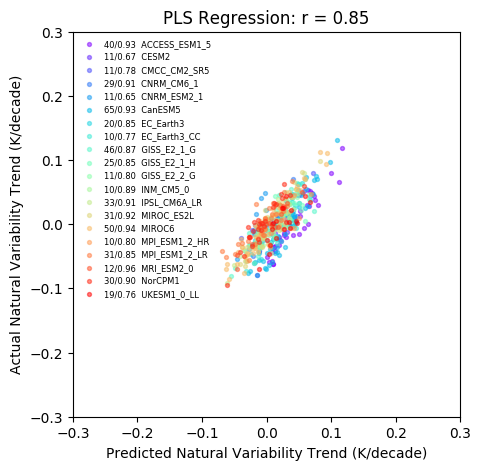

In [4]:
fig, axs_obj = plt.subplots(1, 1, figsize=(5, 5))
import matplotlib.cm as cm

####################################################################################
colors = cm.rainbow(np.linspace(0, 1, 20))
all_r_values = []
for model_idx in range(len(NameValidatationPredictions)):
    modelName = NameValidatationPredictions[model_idx][0]
    ValidationData = NameValidatationPredictions[model_idx][1]
    PredictedData = NameValidatationPredictions[model_idx][2]
    N_ensembles = len(PredictedData)
    
    r_values = []
    for predictant_idx in range(1):
        val = ValidationData[:,predictant_idx]
        pred = PredictedData[:,predictant_idx]
        r = stats.pearsonr(val, pred)[0]
        r_values.append(r)
        
        label_id = str(N_ensembles) + '/' + str(r)[:4] + ' ' + ' ' + modelName
        axs_obj.scatter(PredictedData[:,predictant_idx], ValidationData[:,predictant_idx], label=label_id, color=colors[model_idx], s=8, alpha=0.5)
        axs_obj.legend(loc=0, prop={'size': 6}, frameon=False)

        axs_obj.set_ylim(-.3,.3)
        axs_obj.set_xlim(-.3,.3)
        axs_obj.set_ylabel('Actual Natural Variability Trend (K/decade)')
        axs_obj.set_xlabel('Predicted Natural Variability Trend (K/decade)')
    all_r_values.append(r_values)
axs_obj.set_title('PLS Regression: r = ' + str(np.nanmean(all_r_values))[:4])



Text(0.5, 1.0, 'PLS Regression: r = 0.98')

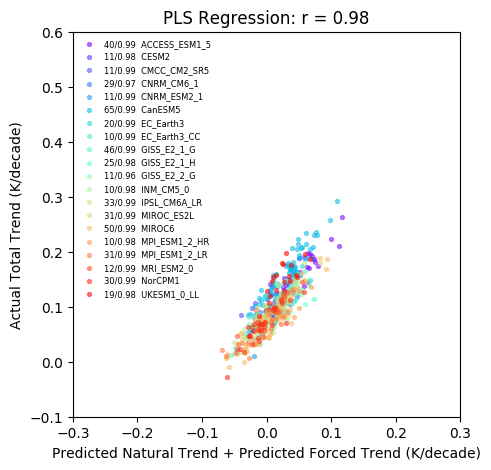

In [5]:
fig, axs_obj = plt.subplots(1, 1, figsize=(5, 5))
import matplotlib.cm as cm

####################################################################################
colors = cm.rainbow(np.linspace(0, 1, 20))
all_r_values = []
for model_idx in range(len(NameValidatationPredictions)):
    modelName = NameValidatationPredictions[model_idx][0]
    ValidationData = TestingTotalTrend[model_idx]
    PredictedData = NameValidatationPredictions[model_idx][2]
    N_ensembles = len(PredictedData)
    
    r_values = []
    for predictant_idx in range(1):
        #val = ValidationData[:,predictant_idx]
        val = ValidationData
        pred = PredictedData[:,0] + PredictedData[:,3]
        r = stats.pearsonr(val, pred)[0]
        r_values.append(r)
        
        label_id = str(N_ensembles) + '/' + str(r)[:4] + ' ' + ' ' + modelName
        axs_obj.scatter(PredictedData[:,predictant_idx], ValidationData, label=label_id, color=colors[model_idx], s=8, alpha=0.5)
        axs_obj.legend(loc=0, prop={'size': 6}, frameon=False)

        axs_obj.set_ylim(-.1,.6)
        axs_obj.set_xlim(-.3,.3)
        axs_obj.set_ylabel('Actual Total Trend (K/decade)')
        axs_obj.set_xlabel('Predicted Natural Trend + Predicted Forced Trend (K/decade)')
    all_r_values.append(r_values)
axs_obj.set_title('PLS Regression: r = ' + str(np.nanmean(all_r_values))[:4])


In [11]:
np.shape(TestingTotalTrend)
np.shape(TestingTotalTrend[model_idx])

/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:1970: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


(19,)

/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


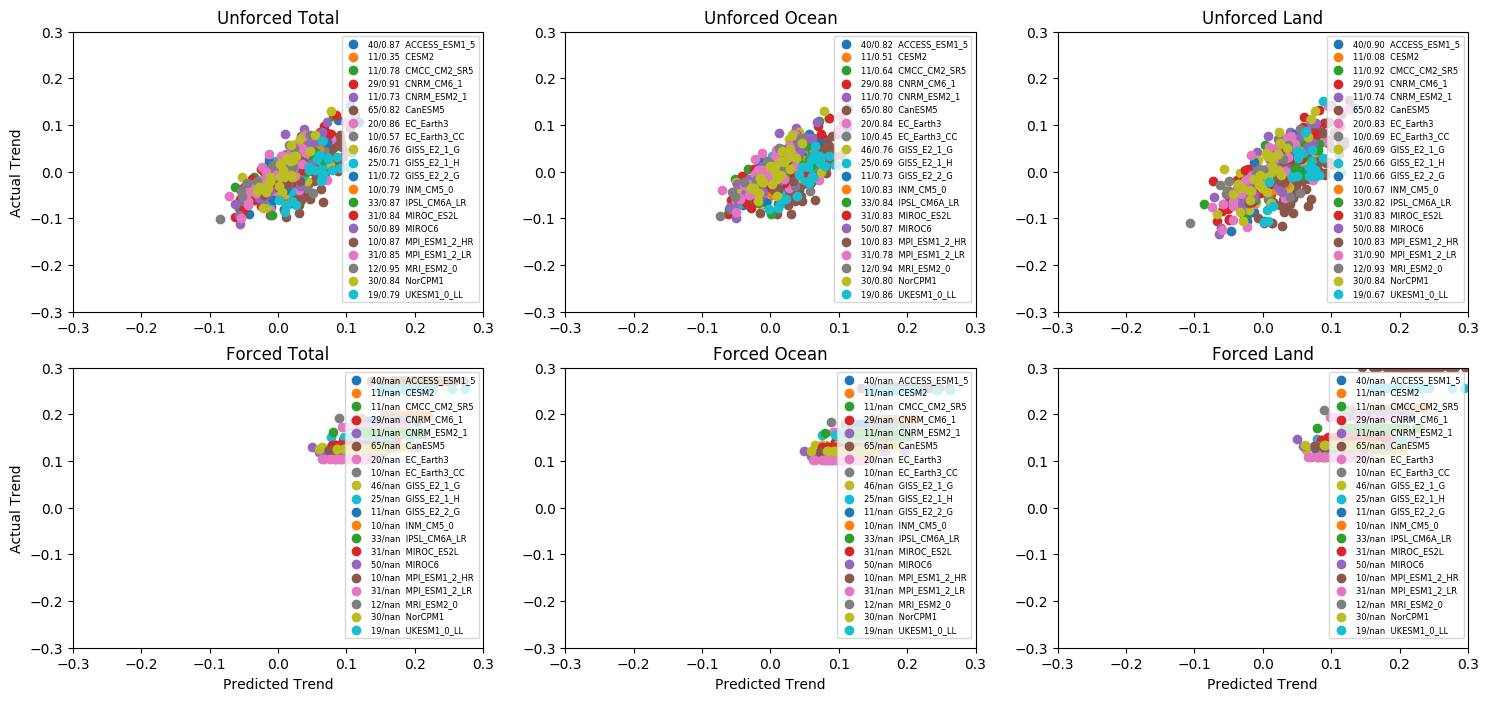

In [15]:
fig, axs = plt.subplots(2,3, figsize=(18,8))

# the second axis in ValidationData and PredictedData is stored as follows
titles = ['Unforced Total', 'Unforced Ocean', 'Unforced Land', 'Forced Total', 'Forced Ocean', 'Forced Land']

all_r_values = []
for model_idx in range(len(NameValidatationPredictions)):
    modelName = NameValidatationPredictions[model_idx][0]
    ValidationData = NameValidatationPredictions[model_idx][1]
    PredictedData = NameValidatationPredictions[model_idx][2]
    N_ensembles = len(PredictedData)

    r_values = []
    for predictant_idx in range(6):
        val = ValidationData[:,predictant_idx]
        pred = PredictedData[:,predictant_idx]
        r = stats.pearsonr(val, pred)[0]
        r_values.append(r)
        axs_obj = axs.flatten()[predictant_idx]
        label_id = str(N_ensembles) + '/' + str(r)[:4] + ' ' + ' ' + modelName
        axs_obj.scatter(PredictedData[:,predictant_idx], ValidationData[:,predictant_idx], label=label_id)
        axs_obj.legend(loc=1, prop={'size': 6})
        axs_obj.set_ylim(-.3,.3)
        axs_obj.set_xlim(-.3,.3)
        axs_obj.set_title(titles[predictant_idx])
        if (predictant_idx == 0) or (predictant_idx == 3):
            axs_obj.set_ylabel('Actual Trend')
        if (predictant_idx >=3):
            axs_obj.set_xlabel('Predicted Trend')
    all_r_values.append(r_values)


In [16]:
print(np.nanmean(all_r_values, axis=0))

[0.79349995 0.77461797 0.76968437        nan        nan        nan]


/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice
  """Entry point for launching an IPython kernel.


In [6]:
from sklearn.cross_decomposition import PLSRegression
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn import model_selection

pls2 = PLSRegression(n_components=20)
pls_model = pls2.fit(TraingPredictorData, TrainingTargetData)
Y_pred = pls2.predict(TestingPredictorData)

Text(0.5, 1.0, 'R^2 = 0.849')

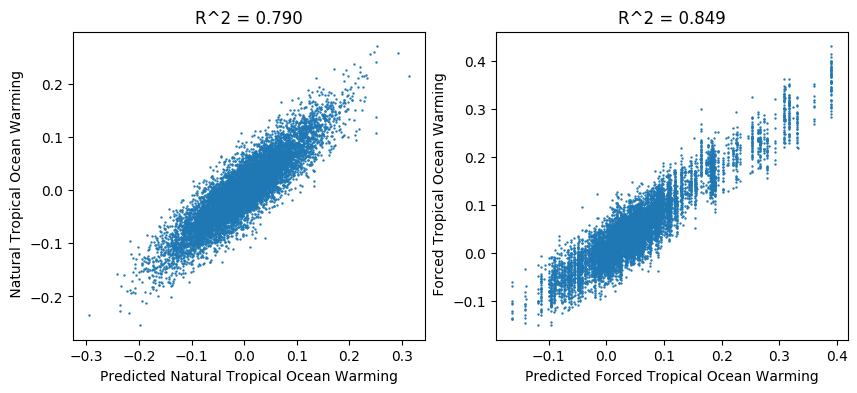

In [7]:
from scipy import stats
fig, axs = plt.subplots(1,2, figsize=(10,4))

################## Natural Predictions ####################
axs[0].scatter(TestingTargetData[:,1], Y_pred[:,1], s=0.5)
axs[0].set_xlabel('Predicted Natural Tropical Ocean Warming')
axs[0].set_ylabel(' Natural Tropical Ocean Warming')
R2 = stats.pearsonr(TestingTargetData[:,1], Y_pred[:,1])[0]**2
axs[0].set_title('R^2 = {accuracy}'.format(accuracy=str(R2)[:5]))

################## Forced Predictions ####################
axs[1].scatter(TestingTargetData[:,4], Y_pred[:,4], s=0.5)
axs[1].set_xlabel('Predicted Forced Tropical Ocean Warming')
axs[1].set_ylabel(' Forced Tropical Ocean Warming')
R2 = stats.pearsonr(TestingTargetData[:,4], Y_pred[:,4])[0]**2
axs[1].set_title('R^2 = {accuracy}'.format(accuracy=str(R2)[:5]))

Text(0.5, 1.0, 'R^2 = 0.810')

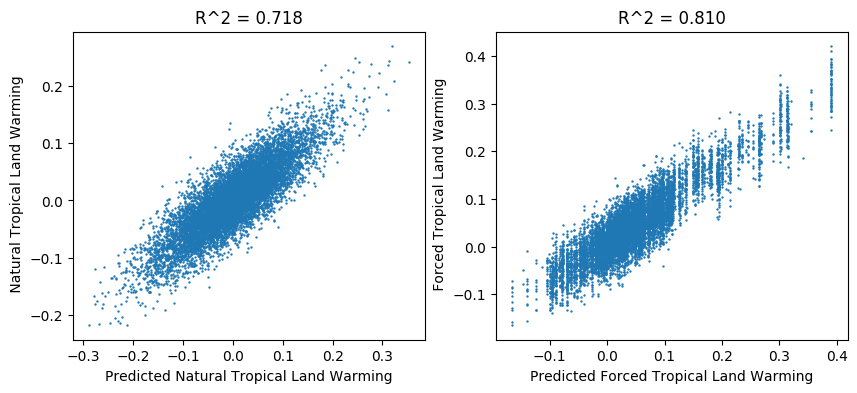

In [4]:
from scipy import stats
fig, axs = plt.subplots(1,2, figsize=(10,4))

################## Natural Predictions ####################
axs[0].scatter(TestingTargetData[:,2], Y_pred[:,2], s=0.5)
axs[0].set_xlabel('Predicted Natural Tropical Land Warming')
axs[0].set_ylabel(' Natural Tropical Land Warming')
R2 = stats.pearsonr(TestingTargetData[:,2], Y_pred[:,2])[0]**2
axs[0].set_title('R^2 = {accuracy}'.format(accuracy=str(R2)[:5]))

################## Forced Predictions ####################
axs[1].scatter(TestingTargetData[:,5], Y_pred[:,5], s=0.5)
axs[1].set_xlabel('Predicted Forced Tropical Land Warming')
axs[1].set_ylabel(' Forced Tropical Land Warming')
R2 = stats.pearsonr(TestingTargetData[:,5], Y_pred[:,5])[0]**2
axs[1].set_title('R^2 = {accuracy}'.format(accuracy=str(R2)[:5]))

Text(0.5, 1.0, 'R^2 = 0.816')

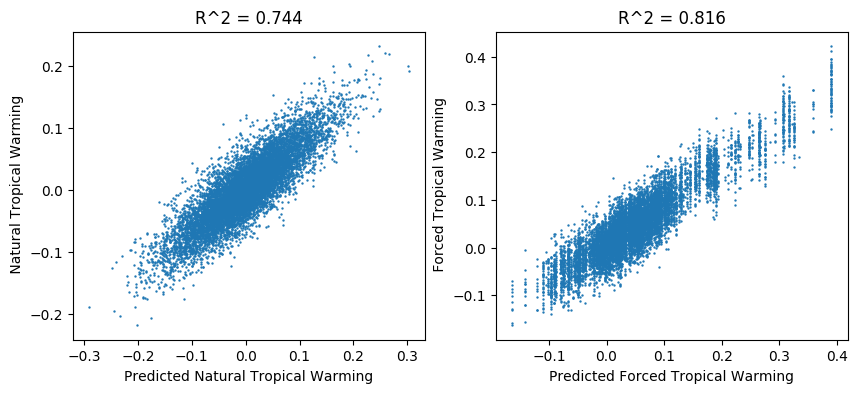

In [5]:
from scipy import stats
fig, axs = plt.subplots(1,2, figsize=(10,4))

################## Natural Predictions ####################
axs[0].scatter(TestingTargetData[:,0], Y_pred[:,0], s=0.5)
axs[0].set_xlabel('Predicted Natural Tropical Warming')
axs[0].set_ylabel(' Natural Tropical Warming')
R2 = stats.pearsonr(TestingTargetData[:,0], Y_pred[:,0])[0]**2
axs[0].set_title('R^2 = {accuracy}'.format(accuracy=str(R2)[:5]))

################## Forced Predictions ####################
axs[1].scatter(TestingTargetData[:,3], Y_pred[:,3], s=0.5)
axs[1].set_xlabel('Predicted Forced Tropical Warming')
axs[1].set_ylabel(' Forced Tropical Warming')
R2 = stats.pearsonr(TestingTargetData[:,3], Y_pred[:,3])[0]**2
axs[1].set_title('R^2 = {accuracy}'.format(accuracy=str(R2)[:5]))

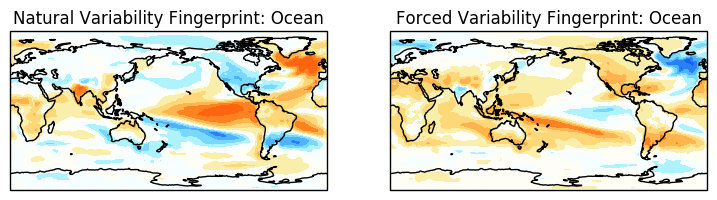

In [124]:
#Plotting is below
lat_bins = np.linspace(-90, 90., 72)
lon_bins = np.linspace(0, 357.5, 144)

lim = np.linspace(-.00009, .00009, 11)
subplot_kw = dict(projection=ccrs.PlateCarree(central_longitude=180))
fig, ax = plt.subplots(1, 2, figsize=(9, 4), subplot_kw=subplot_kw)
####################################################################################
ax[0].coastlines()
#ax[0].set_extent([0.0, -1, -90.0, 90.0])
ax[0].set_title('Natural Variability Fingerprint: Ocean')
coef_map_cyclic, lon = add_cyclic_point(np.reshape(pls_model.coef_[:,1], (72,144)), coord=lon_bins)
im = ax[0].contourf(lon, lat_bins, coef_map_cyclic, 20, levels=lim,
                    transform=ccrs.PlateCarree(), extend='both', cmap=custom_cmap)
####################################################################################
ax[1].coastlines()
#ax[1].set_extent([0.0, -1, -90.0, 90.0])
ax[1].set_title('Forced Variability Fingerprint: Ocean')
coef_map_cyclic, lon = add_cyclic_point(np.reshape(pls_model.coef_[:,4], (72,144)), coord=lon_bins)

im = ax[1].contourf(lon, lat_bins, coef_map_cyclic, 20, levels=lim,
                    transform=ccrs.PlateCarree(), extend='both', cmap=custom_cmap)




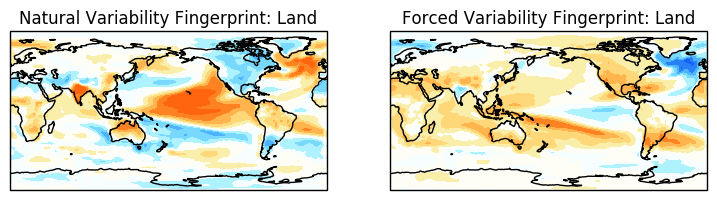

In [125]:
#Plotting is below
lat_bins = np.linspace(-90, 90., 72)
lon_bins = np.linspace(0, 357.5, 144)

lim = np.linspace(-.00009, .00009, 11)
subplot_kw = dict(projection=ccrs.PlateCarree(central_longitude=180))
fig, ax = plt.subplots(1, 2, figsize=(9, 4), subplot_kw=subplot_kw)
####################################################################################
ax[0].coastlines()
#ax[0].set_extent([0.0, -1, -90.0, 90.0])
ax[0].set_title('Natural Variability Fingerprint: Land')
coef_map_cyclic, lon = add_cyclic_point(np.reshape(pls_model.coef_[:,2], (72,144)), coord=lon_bins)
im = ax[0].contourf(lon, lat_bins, coef_map_cyclic, 20, levels=lim,
                    transform=ccrs.PlateCarree(), extend='both', cmap=custom_cmap)
####################################################################################
ax[1].coastlines()
#ax[1].set_extent([0.0, -1, -90.0, 90.0])
ax[1].set_title('Forced Variability Fingerprint: Land')
coef_map_cyclic, lon = add_cyclic_point(np.reshape(pls_model.coef_[:,5], (72,144)), coord=lon_bins)

im = ax[1].contourf(lon, lat_bins, coef_map_cyclic, 20, levels=lim,
                    transform=ccrs.PlateCarree(), extend='both', cmap=custom_cmap)




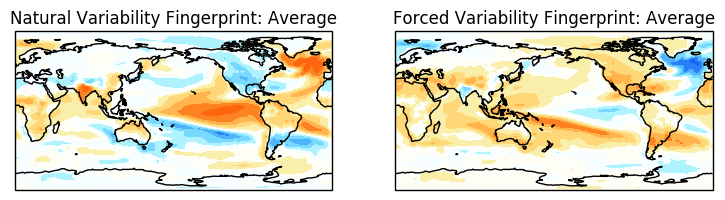

In [126]:
#Plotting is below
lat_bins = np.linspace(-90, 90., 72)
lon_bins = np.linspace(0, 357.5, 144)

lim = np.linspace(-.00009, .00009, 11)
subplot_kw = dict(projection=ccrs.PlateCarree(central_longitude=180))
fig, ax = plt.subplots(1, 2, figsize=(9, 4), subplot_kw=subplot_kw)
####################################################################################
ax[0].coastlines()
#ax[0].set_extent([0.0, -1, -90.0, 90.0])
ax[0].set_title('Natural Variability Fingerprint: Average')
coef_map_cyclic, lon = add_cyclic_point(np.reshape(pls_model.coef_[:,0], (72,144)), coord=lon_bins)
im = ax[0].contourf(lon, lat_bins, coef_map_cyclic, 20, levels=lim,
                    transform=ccrs.PlateCarree(), extend='both', cmap=custom_cmap)
####################################################################################
ax[1].coastlines()
#ax[1].set_extent([0.0, -1, -90.0, 90.0])
ax[1].set_title('Forced Variability Fingerprint: Average')
coef_map_cyclic, lon = add_cyclic_point(np.reshape(pls_model.coef_[:,3], (72,144)), coord=lon_bins)

im = ax[1].contourf(lon, lat_bins, coef_map_cyclic, 20, levels=lim,
                    transform=ccrs.PlateCarree(), extend='both', cmap=custom_cmap)




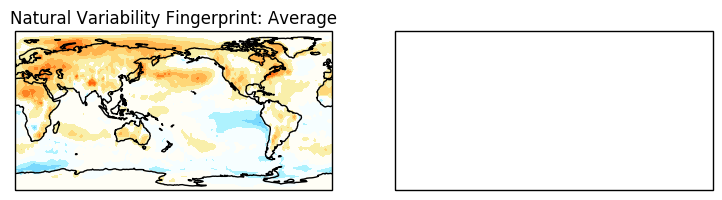

In [3]:
lat_bins = np.linspace(-90, 90., 72)
lon_bins = np.linspace(0, 357.5, 144)

lim = np.linspace(-2, 2, 11)
subplot_kw = dict(projection=ccrs.PlateCarree(central_longitude=180))
fig, ax = plt.subplots(1, 2, figsize=(9, 4), subplot_kw=subplot_kw)
####################################################################################
ax[0].coastlines()
#ax[0].set_extent([0.0, -1, -90.0, 90.0])
ax[0].set_title('Natural Variability Fingerprint: Average')
coef_map_cyclic, lon = add_cyclic_point(ERA5Trend1996_2014, coord=lon_bins)
im = ax[0].contourf(lon, lat_bins, coef_map_cyclic, 20, levels=lim,
                    transform=ccrs.PlateCarree(), extend='both', cmap=custom_cmap)

In [27]:
ERA5Trend1996_2014

array([[ 0.01656201,  0.01625426,  0.01589189, ...,  0.01721569,
         0.01707166,  0.0168917 ],
       [ 0.0756486 ,  0.07221638,  0.06842538, ...,  0.08261162,
         0.08076591,  0.07868954],
       [ 0.11457495,  0.10550231,  0.09832726, ...,  0.14223446,
         0.13167092,  0.12335798],
       ...,
       [ 0.00201934, -0.00369706, -0.00688972, ...,  0.01936562,
         0.00950261,  0.00601595],
       [ 0.05823823,  0.05646827,  0.05376055, ...,  0.0587596 ,
         0.05926812,  0.05963757],
       [ 0.04457938,  0.04436921,  0.0439316 , ...,  0.04528575,
         0.0450632 ,  0.04484116]])

In [4]:
# import statements
import numpy as np
import xarray as xr
import glob
import random
import cartopy.io.shapereader as shpreader
import shapely.geometry as sgeom
from shapely.ops import unary_union
from shapely.prepared import prep

path_to_data = '/home/disk/pna2/aodhan/SurfaceTrendLearning/*.nc'
ModelDataFiles = glob.glob(path_to_data)

# create land sea mask
sample_grid = xr.open_dataset(ModelDataFiles[0]) 
latitudes = sample_grid.Lat.to_numpy()
longitudes = sample_grid.Lon.to_numpy() - 180
land_sea_mask = []
for x in longitudes:
    land_sea_mask_at_latitude = []
    for y in latitudes:
        land_sea_mask_at_latitude.append(is_land(x, y))
    land_sea_mask.append(land_sea_mask_at_latitude)
land_sea_mask = np.transpose(land_sea_mask)

TrainingPredictorData = []
TrainingTargetData = []
TestingPredictorData = []
TestingTargetData = []
for x in range(len(ModelDataFiles)):
    TrainingModelDataFiles = ModelDataFiles[:x] + ModelDataFiles[x+1:]
    TestingModelDataFiles = ModelDataFiles[x] 

    # First, take care of training data
    #########################--------Training--------#########################
    OneCVTrainingPredictorData = []
    OneCVTrainingTargetData = []
    for datafile in TrainingModelDataFiles:
        xarray_file = xr.open_dataset(datafile) 

NameError: name 'is_land' is not defined

In [5]:
xarray_file = xr.open_dataset(ModelDataFiles[0]) 